
-----------------------------------------------------
### Notebook Documentation.
#### TFM
---------------------------------

- First 1 tried pickling the data => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/TFM-serializing_data.ipynb
- That consumed all RAM and wasn't great for batch processing with data augmentation (all pics were loaded in RAM at once). So I started using *image_dataset_from_directory* from *tensorflow* for batch processing, adding a layer for data augmentation => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_2021_01_03.ipynb
- This was not right, because while shuffling of pictures for *train_ds* and *val_ds* (this method can't split data into 3 sets) it lost the connection between labels and pics (they were shuffled), the nn weren't matching anything properly => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_debugging.ipynb
- So I created 3 folders for *train, test and val datasets*. Each of them had a representative sample and different volume => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_creating_2_folders_5_classes.ipynb
- Now it looks like everything is fine, but *train accuracy* is way worse than *val accuracy*. It can be caused because I have a dropout layer for training that maybe is cutting too much connections => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_after_debugging_classification_report.ipynb

So, it's time to run all models and check what's going on.


PENDING:
- using gelu activation layers => https://keras.io/api/layers/activations/ and lrelu

In [2]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


- libraries

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb  6 18:08:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    45W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import VGG16, VGG19,Xception, InceptionResNetV2, DenseNet121, ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers # for data augmentation
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten # Input, Conv2D, 
#from tensorflow.keras.layers import Layer

# optimization
from tensorflow.keras.optimizers import SGD # Adam, 
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# navigating through folder
import os

- paths

In [6]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

# the 5-folders dataset
#input = base_folder+"input/House_Room_Dataset-5_rooms" # for requesting directly pics

# folder 06 train set, 02 test set 01 val set
# folder06 = dataset_2_folders/"

# folder with 0.8 in split for training set, 0.15 for test and 0.05 for val
folder08 = "dataset_3folders_08trainset/"
input = base_folder+"input/"+folder08

src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# insert the directory for using my functions in this notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

- functions

In [7]:
def vgg19_vgg16(data_augmentation, base_model, dropout_layers: bool, dropout_position: str, dropout_percent: float, num_classes, acti_layer):
  '''
  both architectures has the same top model, so we'll built:
  - a model with/without a data augmentation layer
  - the functional nn with frozen layers, whithout top model
  - "empty" top model layers, ready for transfer-learning, with/without dropout in first/middle layer of top model
  - final layer with as much neurons as our classes to infer
  EX: vgg19(data_augmentation=None, base_model= base_model_vgg19, dropout_layers=False, dropout_position= None, dropout_percent=None, num_classes=5)
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))
       
                                                                 
  # vgg16 (Functional)          
  pre_trained.add(base_model)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  # ===> i had to insert this layer when using the data augmentation layer in order to avoid dimension errors with VGG16 and 19
  #pre_trained.add(layers.GlobalAveragePooling2D())

  # adding top model with/without dropout in first/middle position
  # top moddel for vgg19-16 are a flatten layer, 2 dense layers of 4096n and pred layer 
  pre_trained.add(layers.Flatten())
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.Dense(4096,activation=(acti_layer)))

      elif dropout_position == "middle":                  
          pre_trained.add(layers.Dense(4096,activation=(acti_layer)))
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else: 
    pre_trained.add(layers.Dense(4096,activation=(acti_layer)))
  
  pre_trained.add(layers.Dense(4096,activation=(acti_layer)))
  pre_trained.add(layers.Dense(num_classes,activation=('softmax')))

  return pre_trained

def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  Xception, InceptionResNetV2, DenseNet121 have different architecture, but all of them have the same top model. So we add the data augmentation layer,
  load the functional model and add the top model with/without dropout in first/middle position
  works with pre-trained models (Xception, InceptionResNetV2, DenseNet121) for transfer-learning. 
  top layer consisting of 2 layers: globalaverage2d layer and predictions layer.
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
  
  # last layer
  pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))
  return pre_trained


def plotting_model(model, epochs, name, location):
  '''
  Plotting the training and validation loss and accuracy
  :model: nn
  :epochs
  :name: name to save the final image
  :location: path to save the image
  '''

  f,ax=plt.subplots(2, 1, figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), history.history["val_loss"], label="test_loss")
  ax[0].grid(visible=True, which="both", axis='both')
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), history.history["val_accuracy"], label="test_acc")
  ax[1].grid(visible=True, which="both", axis='both')
  ax[1].legend()

  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  
  plt.savefig(location)
  plt.show()
  

def model_evaluation(evaluation, output_folder:str, name:str):
  '''
  evaluation the model with test_ds
  :evaluation: model.evaluate(val_dataset, batch_size, return_dict=True)
  :output_folder: path to save the json
  :name: name of the file
  '''
  models_metrics = {}  
  models_metrics[m] = evaluation
  # saving the metris in json file
  with open(output_folder+name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)
  return models_metrics

def classification_report_pic(y_pred, y_target, class_names, output_folder, name):
  '''
  prints inline the classification report and also saves a pic with results
  - y_pred = inferences: n.argmax( model.predict(test_ds), axis=1)
  - validation_ds = the test dataset (if you have 3 folders)
  - class_names
  - output_folder: the path to save the pic
  - name
  '''  
  print(classification_report(y_pred , y_target, target_names=class_names))

  
  clf_report = classification_report(y_pred , y_target, target_names=class_names, output_dict=True )
  # .iloc[:-1, :] to exclude support
  plt.figure(figsize = (10,8))
  plt.title("classification report: "+name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  plt.savefig(output_folder+name+"-classification_report.png")
  plt.show()

def confusion_matrix_report(y_pred, y_target,  class_names, output_folder, name):
  '''
  displays inline a pic and also saves it
  - y_pred: inferences
  - y_target: labels
  - class_names
  - output_folder: path to save pic
  - name
  '''
  
  cm = confusion_matrix(y_target, y_pred, normalize="true" ) #,  labels=[class_names])
  df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
  fig = plt.figure(figsize = (10,8))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
  plt.title("confusion matrix: "+name)
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)
  plt.savefig(output_folder+name+"-confusion_matrix.png")
  plt.show()

# getting pics from folder instead of pickling them

In previous versions I used a pickled dataset to work with. That was quite a mess, because it loads the full dataset in memory, so sometimes the notebook crashed. Now I batch process the pictures with this keras method => https://keras.io/examples/vision/image_classification_from_scratch/
- *image_dataset_from_directory* has no train-test-val. it has just train-val.

In [8]:
image_size = (128,128)
batch_size = 128 # 32

In [9]:
# train set
# https://www.tensorflow.org/tutorials/images/classification
# i'll take the whole of the folder (already separated)
train_path = input+'train_ds/'
train_ds = image_dataset_from_directory(
    train_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 4208 files belonging to 5 classes.


In [10]:
# i'll take the whole of the folder (already separated)
test_path = input+"test_ds"
test_ds = image_dataset_from_directory(
    test_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 787 files belonging to 5 classes.


In [11]:
# i'll take the whole of the folder (already separated)
val_path = input+"val_ds"
val_ds = image_dataset_from_directory(
    val_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 265 files belonging to 5 classes.


In [12]:
# checking numbers
paths = ['train_ds/', 'test_ds/','val_ds/']
for p in paths:
  for dir,subdir,files in os.walk(input + p):
    print(dir,' => ', p, str(len(files)))

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Kitchen  =>  train_ds/ 772
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Livingroom  =>  train_ds/ 1028
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Dinning  =>  train_ds/ 926
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Bathroom  =>  train_ds/ 484
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Bedroom  =>  train_ds/ 998
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/test_ds/  =>  test_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input

In [13]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

# data augmentation

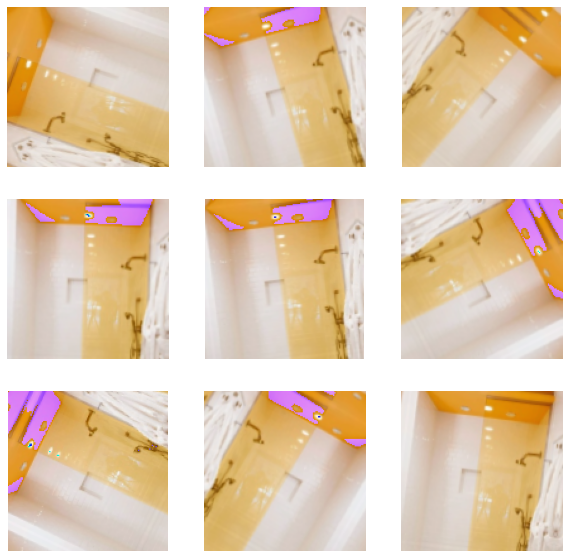

In [14]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
def random_invert(factor=0.3):
  return layers.Lambda(lambda x: random_invert_img(x, factor))


# to check => https://stepup.ai/custom_data_augmentation_keras/
# https://github.com/dufourpascal/stepupai/tree/master/tutorials/data_augmentation

# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [  
  #random_invert(), # making the model to malfunction, errors in the for loop below
  layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.01),    
  layers.RandomWidth(0.01),
  layers.RandomHeight(0.01),
  #layers.RandomTranslation((-0.1,0.1),(-0.1,0.1), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0)
  layers.RandomContrast(0.1)    
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# vgg19 with/without data augmentation

In [15]:
# VGG16
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_xception    =  Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_inception   = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args
base_model_resnet50    = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args

models_dict = {
    # vgg16
    #"vgg16_NOdataAug_NOdropout"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # #"vgg16_NOdataAug_NOdropout_gelu" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),

    # "vgg16_dataAug_dropoutFirst02"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_dataAug_dropoutFirst02_gelu": vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_NOdataAug_dropoutFirst02" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_NOdataAug_dropoutFirst02_gelu" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_dataAug_dropoutMiddle02"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_dataAug_dropoutMiddle02_gelu"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_NOdataAug_dropoutMiddle02": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_NOdataAug_dropoutMiddle02_gelu": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_dataAug_NOdropout"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # "vgg16_dataAug_NOdropout_gelu"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),   

    # # vgg19
    # "vgg19_NOdataAug_NOdropout"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # "vgg19_NOdataAug_NOdropout_gelu"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),

    # "vgg19_dataAug_dropoutFirst02"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_dataAug_dropoutFirst02_gelu"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),
    
    # "vgg19_NOdataAug_dropoutFirst02" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_NOdataAug_dropoutFirst02_gelu" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg19_dataAug_dropoutMiddle02"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_dataAug_dropoutMiddle02_gelu"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),
    
    # "vgg19_NOdataAug_dropoutMiddle02": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_NOdataAug_dropoutMiddle02_gelu": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),
    
    # "vgg19_dataAug_NOdropout"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # "vgg19_dataAug_NOdropout_gelu"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),
    
    # xception
    #"xception_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_xception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "xception_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "xception_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "xception_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "xception_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    "xception_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    
    # inception resnet v2
    "InceptionResNetV2_Aug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_inception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "InceptionResNetV2_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "InceptionResNetV2_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "InceptionResNetV2_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "InceptionResNetV2_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    "InceptionResNetV2_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),

    # densenet121
    "densenet121_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "densenet121_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "densenet121_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "densenet121_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "densenet121_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    "densenet121_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),

    # resnet50
    "resnet50_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "resnet50_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "resnet50_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "resnet50_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "resnet50_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    "resnet50_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
}

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
opt = SGD(momentum=0.9) # lr=0.01, 

callbacks = [
    EarlyStopping(
        # Stop training when the metric is no longer improving
        monitor='val_loss', mode="min", #"val_accuracy", mode="max", #  "val_loss",
        # "no longer improving" being defined as "no better than 1e-4 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=15,
        verbose=1
    )
]

In [ ]:
epochs = 100
for m in models_dict:
  print("\n", m)
  models_dict[m].summary()

  models_dict[m].compile( optimizer = opt, #"adam", 
                loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                metrics=['accuracy'] # "recall"
                )

  history = models_dict[m].fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        callbacks = callbacks # <=== REMOVE CALLBACK for full results
        )
  
  number_of_epochs_it_ran = len(history.history['loss']) 
  print("run epochs: ",number_of_epochs_it_ran)
  name = m
  models_dict[m].save(output_folder+name+".h5")

  # saving model accuracy/loss graph
  plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 
  
  # saving model metrics to json
  evaluation = models_dict[m].evaluate(test_ds, batch_size=batch_size, return_dict=True)
  model_evaluation(evaluation, output_folder, name)

  # get inferences
  y_pred_float = models_dict[m].predict(test_ds)
  y_pred = np.argmax(y_pred_float, axis=1)

  # get real labels
  y_target = tf.concat([y for x, y in test_ds], axis=0) 

  # classification and confusion matrix reports
  classification_report_pic(y_pred, y_target,  class_names, output_folder, name)
  confusion_matrix_report(y_pred, y_target, class_names, output_folder, name)


 xception_dataAug_NOdropout
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 124s 4s/step - loss: 9.1315 - accuracy: 0.3562 - val_loss: 27.0475 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 101ms/step - loss: 36.0233 - accuracy: 0.0299 - val_loss: 19.3586 - val_accuracy: 0.2008
Epoch 3/100
33/33 [==============================] - 3s 94ms/step - loss: 24.3910 - accuracy: 0.0915 - val_loss: 9.1739 - val_accuracy: 0.3380
Epoch 4/100
33/33 [==============================] - 3s 103ms/step - loss: 26.6418 - accuracy: 0.1150 - val_loss: 9.1661 - val_accuracy: 0.3812
Epoch 5/100
33/33 [==============================] - 3s 92ms/step - loss: 26.0655 - accuracy: 0.1017 - val_loss: 10.6912 - val_accuracy: 0.3278
Epoch 6/100
33/33 [==============================] - 3s 94ms/step - loss: 25.3513 - accuracy: 0.0863 - val_loss: 12.0220 - val_accuracy: 0.3202
Epoch 7/100
33/33 [==============================] - 3s 95ms/step - loss: 25.3153 - accuracy: 0.0806 - val_loss: 9.7883 - val_accuracy: 0.3685
Epoch 

- load a trained model

In [ ]:
# error above for misplacing y_pred and test_ds in function args
'''densenet121 = load_model(output_folder+"densenet121_dataAug_dropoutFirst02.h5")
evaluation  = densenet121.evaluate(testds, batch_size=batch_size, return_dict=True)'''

In [ ]:
# saving model metrics to json
'''model_evaluation(evaluation, output_folder, "densenet121_dataAug_dropoutFirst02.h5")'''

In [ ]:
# get inferences
'''y_pred_float = models_dict[m].predict(test_ds)
y_pred = np.argmax(y_pred_float, axis=1) '''

In [ ]:
# classification and confusion matrix reports
'''classification_report_pic(y_pred, val_ds,  class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")
confusion_matrix_report(y_pred, val_ds, class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")'''